In [ ]:
#Завдання №1 Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір).

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import string
import re
import numpy as np

import tensorflow as tf

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

In [7]:
with open("./ukr-eng/ukr.txt", "r", encoding = "utf-8") as f:
    text_pairs = [
        (line.split("\t")[0], f" {line.split("\t")[1]} ")
        for line in f if "\t" in line
    ]
    
col_eng = 45
col_ukr = 60
header = f"║ {'ENGLISH':^{col_eng}} ║ {'UKRAINIAN':^{col_ukr}} ║"
separator_top = f"╔{'═' * (col_eng + 2)}╦{'═' * (col_ukr + 2)}╗"
separator_mid = f"╠{'═' * (col_eng + 2)}╬{'═' * (col_ukr + 2)}╣"
separator_bottom = f"╚{'═' * (col_eng + 2)}╩{'═' * (col_ukr + 2)}╝"

print(f"Завантажено пар: {len(text_pairs)}")
print(separator_top)
print(header)
print(separator_mid)

for eng, ukr in random.sample(text_pairs, 5):
    eng_text = (eng[:col_eng-3] + '...') if len(eng) > col_eng else eng
    ukr_text = (ukr[:col_ukr-3] + '...') if len(ukr) > col_ukr else ukr
    
    print(f"║ {eng_text:<{col_eng}} ║ {ukr_text:<{col_ukr}} ║")

print(separator_bottom)

Завантажено пар: 159432
╔═══════════════════════════════════════════════╦══════════════════════════════════════════════════════════════╗
║                    ENGLISH                    ║                          UKRAINIAN                           ║
╠═══════════════════════════════════════════════╬══════════════════════════════════════════════════════════════╣
║ You're my friend.                             ║  Ти моя приятелька.                                          ║
║ What do you plan to do on Monday?             ║  Що ти плануєш робити в понеділок?                           ║
║ I make it a rule never to ask a woman how ... ║  Я взяв собі за правило ніколи не питати жінку, скільки ї... ║
║ Are you a vampire?                            ║  Ви вампір?                                                  ║
║ Tom refused to back down.                     ║  Том відмовився відступити.                                  ║
╚═══════════════════════════════════════════════╩═══════════════════════

In [10]:
random.shuffle(text_pairs)
dataset = text_pairs[:100000]

total_size = len(dataset)
train_end = int(total_size * 0.70)
val_end = int(total_size * 0.85)

train_pairs = dataset[:train_end]
val_pairs = dataset[train_end:val_end]
test_pairs = dataset[val_end:]

stats = [
    ("Total", len(dataset)),
    ("Training", len(train_pairs)),
    ("Validation", len(val_pairs)),
    ("Testing", len(test_pairs))
]

print("Розподіл вибірки:")
for label, count in stats:
    print(f"{label:<12}: {count:,} рядків")

Розподіл вибірки:
Total       : 100,000 рядків
Training    : 70,000 рядків
Validation  : 15,000 рядків
Testing     : 15,000 рядків


In [18]:

# Векторизація слів, словника
strip_chars = string.punctuation.replace("[", "").replace("]", "")

vocabulary_size = 16000
sequence_length = 20
batch_size = 64

def ukr_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

# Ініціалізація векторизаторів
eng_vector = keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

ukr_vector = keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=ukr_standardization,
)

# Підготовка даних та адаптація, навчання словника
train_eng, train_ukr = zip(*train_pairs)
eng_vector.adapt(list(train_eng))
ukr_vector.adapt(list(train_ukr))

def print_vocab_info(vectorizer, name):
    vocab = vectorizer.get_vocabulary()
    print(f"--- {name} Vocabulary ---")
    print(f"Size: {len(vocab)}")
    sample_words = [str(word) for word in vocab[10:20]]
    print(sample_words)
    print("-" * (20 + len(name)))

print_vocab_info(eng_vector, "English")
print_vocab_info(ukr_vector, "Ukrainian")

--- English Vocabulary ---
Size: 8250
['do', 'im', 'have', 'dont', 'was', 'me', 'he', 'mary', 'in', 'it']
---------------------------
--- Ukrainian Vocabulary ---
Size: 16000
['ти', 'Тома', 'я', 'з', 'у', 'Це', 'У', 'в', 'Ви', 'мене']
-----------------------------


In [20]:
def format_dataset(eng, ukr):
    
    eng = eng_vector(eng)
    ukr = ukr_vector(ukr)
    
    # Decoder_inputs: речення без останнього слова (для входу декодера)
    # Targets: речення без першого слова (те, що модель має передбачити)
    return (
        {
            "encoder_inputs": eng, 
            "decoder_inputs": ukr[:, :-1]
        }, 
        ukr[:, 1:]
    )

def make_dataset(pairs):
    """
    Формування оптимізованого tf.data.Dataset.
    """
    eng_texts, ukr_texts = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(ukr_texts)))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset.cache().shuffle(2048).prefetch(tf.data.AUTOTUNE)
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# Візуалізація структури одного батча
print(" Структура тензорів у батчі:")
print("-" * 40)
for inputs, targets in train_ds.take(1):
    print(f"Encoder Inputs : {inputs['encoder_inputs'].shape}")
    print(f"Decoder Inputs : {inputs['decoder_inputs'].shape}")
    print(f"Targets: {targets.shape}")

 Структура тензорів у батчі:
----------------------------------------
Encoder Inputs : (64, 20)
Decoder Inputs : (64, 20)
Targets: (64, 20)


In [23]:
class EncoderLayer(layers.Layer):
    def __init__(self, hidden_size, intermediate_size, head_count, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.head_count = head_count
        self.multi_head_attention = layers.MultiHeadAttention(
            num_heads=head_count, key_dim=hidden_size
        )
        self.network_ffn = keras.Sequential(
            [
                layers.Dense(intermediate_size, activation="relu"),
                layers.Dense(hidden_size),
            ]
        )
        self.normalization_1 = layers.LayerNormalization()
        self.normalization_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            combined_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            combined_mask = None
        
        attention_step = self.multi_head_attention(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        x = self.normalization_1(inputs + attention_step)
        ffn_step = self.network_ffn(x)
        return self.normalization_2(x + ffn_step)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_length, vocab_depth, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.word_embedding = layers.Embedding(
            input_dim=vocab_depth, output_dim=hidden_size
        )
        self.position_embedding = layers.Embedding(
            input_dim=max_length, output_dim=hidden_size
        )
        self.max_length = max_length
        self.vocab_depth = vocab_depth
        self.hidden_size = hidden_size

    def call(self, inputs):
        input_len = ops.shape(inputs)[-1]
        pos_range = ops.arange(start=0, stop=input_len, step=1)
        embedded_words = self.word_embedding(inputs)
        embedded_pos = self.position_embedding(pos_range)
        return embedded_words + embedded_pos

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)


class DecoderLayer(layers.Layer):
    def __init__(self, hidden_size, intermediate_size, head_count, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.head_count = head_count
        self.internal_attention = layers.MultiHeadAttention(
            num_heads=head_count, key_dim=hidden_size
        )
        self.external_attention = layers.MultiHeadAttention(
            num_heads=head_count, key_dim=hidden_size
        )
        self.ffn_block = keras.Sequential(
            [
                layers.Dense(intermediate_size, activation="relu"),
                layers.Dense(hidden_size),
            ]
        )
        self.layer_norm_v1 = layers.LayerNormalization()
        self.layer_norm_v2 = layers.LayerNormalization()
        self.layer_norm_v3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        dec_inputs, enc_outputs = inputs
        causal_mask = self._build_causal_mask(dec_inputs)

        if mask is not None:
            dec_mask, enc_mask = mask[0], mask[1]
        else:
            dec_mask = enc_mask = None

        step_1 = self.internal_attention(
            query=dec_inputs,
            value=dec_inputs,
            key=dec_inputs,
            attention_mask=causal_mask,
            query_mask=dec_mask,
        )
        x = self.layer_norm_v1(dec_inputs + step_1)

        step_2 = self.external_attention(
            query=x,
            value=enc_outputs,
            key=enc_outputs,
            query_mask=dec_mask,
            key_mask=enc_mask,
        )
        x = self.layer_norm_v2(x + step_2)

        step_3 = self.ffn_block(x)
        return self.layer_norm_v3(x + step_3)

    def _build_causal_mask(self, inputs):
        input_dims = ops.shape(inputs)
        batch, length = input_dims[0], input_dims[1]
        indices_i = ops.arange(length)[:, None]
        indices_j = ops.arange(length)
        mask_base = ops.cast(indices_i >= indices_j, dtype="int32")
        mask_3d = ops.reshape(mask_base, (1, length, length))
        return ops.repeat(mask_3d, batch, axis=0)

In [ ]:
dim_model = 256
ffn_units = 2048
head_num = 8

src_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
src_emb = TokenAndPositionEmbedding(sequence_length, vocabulary_size, dim_model)(src_inputs)
enc_features = EncoderLayer(dim_model, ffn_units, head_num)(src_emb)
encoder_engine = keras.Model(src_inputs, enc_features)

tgt_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
context_inputs = keras.Input(shape=(None, dim_model), name="decoder_state_inputs")

tgt_emb = TokenAndPositionEmbedding(sequence_length, vocabulary_size, dim_model)(tgt_inputs)

decoder_layer_node = DecoderLayer(dim_model, ffn_units, head_num)([tgt_emb, context_inputs])
drop_layer = layers.Dropout(0.5)(decoder_layer_node)
prediction_layer = layers.Dense(vocabulary_size, activation="softmax")(drop_layer)

decoder_engine = keras.Model([tgt_inputs, context_inputs], prediction_layer)

full_transformer_outputs = decoder_engine([tgt_inputs, enc_features])
transformer_model = keras.Model(
    inputs={
        "encoder_inputs": src_inputs, 
        "decoder_inputs": tgt_inputs
    },
    outputs=full_transformer_outputs,
    name="translation_transformer"
)

C:\Users\Dmytrik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'functional_7' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [30]:
tiny_dim = 32
tiny_ff = 128
tiny_heads = 2
cpu_batch = 45
training_cycles = 5

def create_ultra_lite_ds(pairs):
    e_txt, u_txt = zip(*pairs)
    ds = tf.data.Dataset.from_tensor_slices((list(e_txt), list(u_txt)))
    ds = ds.batch(cpu_batch)
    return ds.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

train_lite = create_ultra_lite_ds(train_pairs)
val_lite = create_ultra_lite_ds(val_pairs)

input_enc = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
emb_enc = TokenAndPositionEmbedding(sequence_length, vocabulary_size, tiny_dim)(input_enc)
feat_enc = EncoderLayer(tiny_dim, tiny_ff, tiny_heads)(emb_enc)
engine_enc = keras.Model(input_enc, feat_enc)

input_dec = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
state_dec = keras.Input(shape=(None, tiny_dim), name="decoder_state_inputs")
emb_dec = TokenAndPositionEmbedding(sequence_length, vocabulary_size, tiny_dim)(input_dec)
feat_dec = DecoderLayer(tiny_dim, tiny_ff, tiny_heads)([emb_dec, state_dec])
feat_dec = layers.Dropout(0.2)(feat_dec)
out_dec = layers.Dense(vocabulary_size, activation="softmax")(feat_dec)
engine_dec = keras.Model([input_dec, state_dec], out_dec)

transformer_output = engine_dec([input_dec, feat_enc])
model_lite = keras.Model(
    inputs={
        "encoder_inputs": input_enc, 
        "decoder_inputs": input_dec
    },
    outputs=transformer_output
)

model_lite.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_lite.fit(
    train_lite,
    epochs=training_cycles,
    validation_data=val_lite
)

Epoch 1/5


C:\Users\Dmytrik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'functional_20' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1556/1556 ━━━━━━━━━━━━━━━━━━━━ 1229s 778ms/step - accuracy: 0.3063 - loss: 5.2964 - val_accuracy: 0.4211 - val_loss: 3.9650
Epoch 2/5
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 1196s 769ms/step - accuracy: 0.4539 - loss: 3.6648 - val_accuracy: 0.5176 - val_loss: 3.0786
Epoch 3/5
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 3119s 2s/step - accuracy: 0.5283 - loss: 2.8893 - val_accuracy: 0.5678 - val_loss: 2.6355
Epoch 4/5
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 1171s 753ms/step - accuracy: 0.5766 - loss: 2.4183 - val_accuracy: 0.5919 - val_loss: 2.4020
Epoch 5/5
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 1157s 744ms/step - accuracy: 0.6081 - loss: 2.1069 - val_accuracy: 0.6031 - val_loss: 2.3042


In [ ]:
target_dict = ukr_vector.get_vocabulary()
idx_to_word = {i: word for i, word in enumerate(target_dict)}
limit_len = 20

def fetch_translation(text_query):
    encoded_query = eng_vector([text_query])
    prediction_text = "[start]"
    
    for _ in range(limit_len):
        tokenized_part = ukr_vector([prediction_text])
        current_tokens = tokenized_part[0]
        actual_len = len(current_tokens[current_tokens != 0]) - 1
        
        output_probs = model_lite.predict(
            {
                "encoder_inputs": encoded_query,
                "decoder_inputs": tokenized_part[:, :-1],
            },
            verbose=0
        )

        best_idx = np.argmax(output_probs[0, actual_len, :])
        result_word = idx_to_word[best_idx]
        
        if result_word == "[end]" or result_word == "":
            break
            
        prediction_text += " " + result_word
        
    return prediction_text.replace("[start]", "").strip()

for _ in range(3):
    random_query = random.choice([pair[0] for pair in test_pairs])
    final_output = fetch_translation(random_query)
    print(f"EN: {random_query}")
    print(f"UK: {final_output}")
    print("-" * 30)

EN: Are you still looking for a job?
UK: все ще де ця робота
------------------------------
EN: I thought Tom was awake.
UK: Томе ти не спав
------------------------------
EN: I know you're thinking about me.
UK: ти про мене думаєш
------------------------------


In [ ]:
#Завдання 2
# Реалізуємо за допомогою GAN на основі датасету Fashion MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latent_size = 100
batch_size = 128
lr = 0.0002

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.37MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 808kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 7.16MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.1MB/s]


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

In [49]:
# Навчання моделі
D = Discriminator().to(device)
G = Generator(latent_size).to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        
        z = torch.randn(images.size(0), latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

Epoch [1/10], d_loss: 0.2316, g_loss: 2.7238
Epoch [2/10], d_loss: 0.1033, g_loss: 6.5582
Epoch [3/10], d_loss: 0.1534, g_loss: 5.3829
Epoch [4/10], d_loss: 0.2358, g_loss: 5.0209
Epoch [5/10], d_loss: 0.4797, g_loss: 3.8839
Epoch [6/10], d_loss: 0.2206, g_loss: 3.5486
Epoch [7/10], d_loss: 0.2472, g_loss: 3.8837
Epoch [8/10], d_loss: 0.2618, g_loss: 3.6467
Epoch [9/10], d_loss: 0.6198, g_loss: 5.0955
Epoch [10/10], d_loss: 0.5177, g_loss: 3.1415


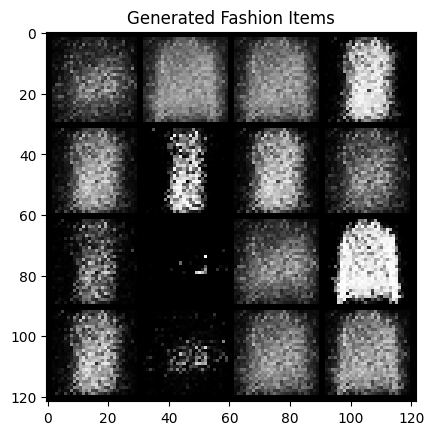

In [50]:
with torch.no_grad():
    z = torch.randn(16, latent_size).to(device)
    fake_images = G(z).cpu()
    grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title("Generated Fashion Items")
    plt.show()

In [ ]:
# Завдання 3

In [ ]:
# Знайдіть українські мовні моделі, наведіть приклади роботи з ними (через pipeline) на завданнях (translation)

In [63]:
import os
import torch
import warnings
from transformers import pipeline, logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.set_verbosity_error()
warnings.filterwarnings("ignore")

device = 0 if torch.cuda.is_available() else -1

translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", device=device)
generator = pipeline("text-generation", model="gpt2", device=device)

prompt = "To be, or not to be, that is the question: Whether 'tis nobler in the mind to"

gen_out = generator(prompt, max_new_tokens=40, do_sample=True, temperature=0.7, pad_token_id=50256)
gen_text = gen_out[0]["generated_text"]

trans_out = translator(gen_text, src_lang="eng_Latn", tgt_lang="ukr_Cyrl")
translated_text = trans_out[0]["translation_text"]

print(f"--- Original ---\n{gen_text}")
print(f"\n--- Translated ---\n{translated_text}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



--- Original ---
To be, or not to be, that is the question: Whether 'tis nobler in the mind to say "I am a man"; or "I am a man" when you must put a question to it, but at the same time to say "I am a man because I am a man

--- Translated ---
Бути чи не бути, це питання: чи 'тіс шляхетніше в розумі сказати "Я людина"; або "Я людина", коли ви повинні поставити йому питання, але в той же час сказати "Я людина, тому що я людина
